In [16]:
from google.colab import files
uploaded = files.upload()

Saving NucSegTest.zip to NucSegTest (1).zip


In [17]:
!unzip -q NucSegTest.zip -d /content
!ls -R /content

replace /content/NucSegTest/Images/S10-11717_Med_D1_405_1354.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/NucSegTest/Images/S10-11717_Med_D2_405_1270.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content:
 NucSegTest	       NucSegTest.zip	   sample_data
'NucSegTest (1).zip'   overlays_cellpose

/content/NucSegTest:
Images	Labels

/content/NucSegTest/Images:
S10-11717_Med_D1_405_1354.tif  S18-22259_D4_405_2366.tif
S10-11717_Med_D2_405_1270.tif  S18-22259_D6_405_1987.tif
S10-11717_Med_D2_405_609.tif   S18-22259_D6_405_2273.tif
S10-11717_Med_D7_405_1050.tif  S18-22259_D6_405_2377.tif
S10-11717_Med_D8_405_1093.tif  S18-22259_D8_405_1924.tif
S10-11717_Med_D8_405_1226.tif  S19-18536_D10_405_305.tif
S10-11717_Med_D8_405_2358.tif  S19-18536_D1_405_522.tif
S10-11717_Med_D9_405_1485.tif  S19-18536_D1_405_701.tif
S10-11717_Med_D9_405_219.tif   S19-18536_D2_405_579.tif
S10-11717_Med_D9_405_482.tif   S19-18536_D2_405_607.tif
S18-11155_D1_405_863.tif       S19-18536_D2_405_675.tif
S18

In [18]:
!pip install -q cellpose[all] scikit-image matplotlib numpy tifffile

In [19]:
import os, glob, numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, segmentation, feature
from scipy import ndimage as ndi

IMG_DIR = "/content/NucSegTest/Images"
LBL_DIR = "/content/NucSegTest/Labels"

print("Images:", len(glob.glob(os.path.join(IMG_DIR, "*.tif"))))
print("Label TIFs:", len(glob.glob(os.path.join(LBL_DIR, "*.tif"))))
print("Label NPys:", len(glob.glob(os.path.join(LBL_DIR, "*.npy"))))

Images: 50
Label TIFs: 50
Label NPys: 50


S10-11717_Med_D1_405_1354.tif (512, 512) uint8


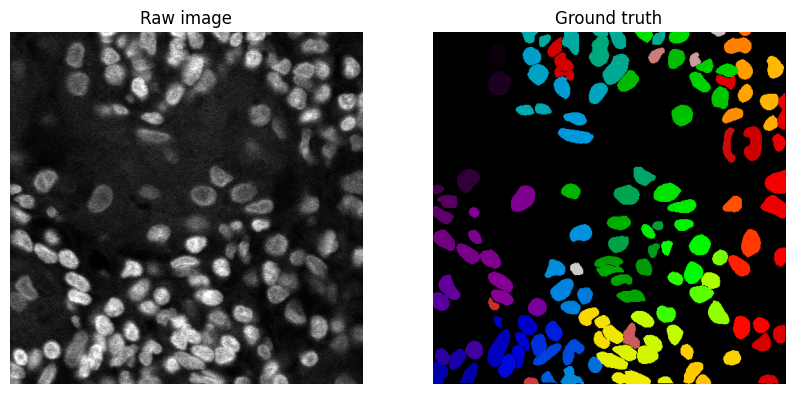

In [20]:
img_path = sorted(glob.glob(os.path.join(IMG_DIR, "*.tif")))[0]
gt_tif_path = os.path.join(LBL_DIR, os.path.basename(img_path))

img = io.imread(img_path)
gt  = io.imread(gt_tif_path)

print(os.path.basename(img_path), img.shape, img.dtype)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img, cmap="gray"); ax[0].set_title("Raw image"); ax[0].axis("off")
ax[1].imshow(gt,  cmap="nipy_spectral"); ax[1].set_title("Ground truth"); ax[1].axis("off")
plt.show()


In [21]:
!pip install -q cellpose[all] scikit-image matplotlib numpy tifffile

In [22]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

CUDA available: True
Tesla T4


GPU available: True


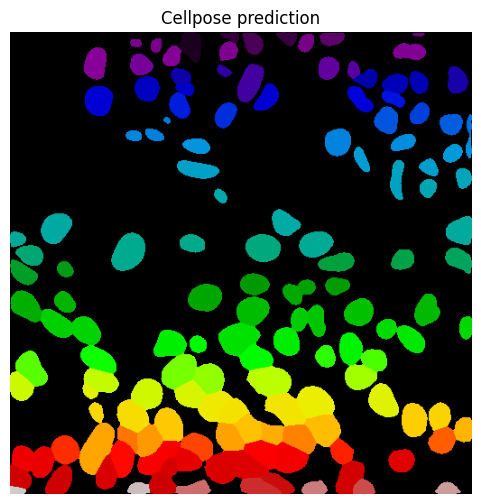

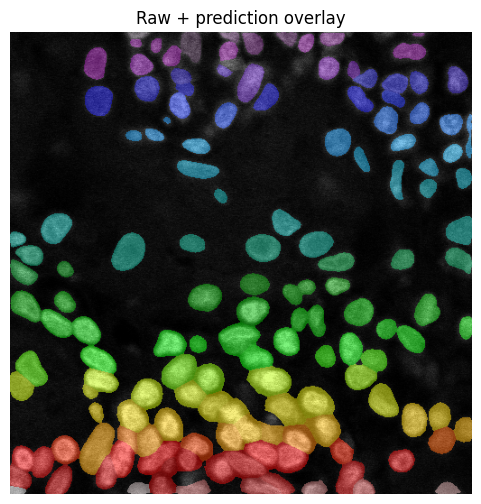

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from cellpose import models

use_gpu = torch.cuda.is_available()
print("GPU available:", use_gpu)

model = models.CellposeModel(gpu=use_gpu, pretrained_model='nuclei')

# Normalize
imgf = img.astype(np.float32)
imgn = (imgf - imgf.min()) / (imgf.max() - imgf.min() + 1e-8)

masks, flows, styles = model.eval(
    [imgn],
    diameter=None,
    do_3D=False,
    batch_size=8
)

pred = masks[0] # mask containing different ids of the cells

plt.figure(figsize=(6,6))
plt.imshow(pred, cmap='nipy_spectral'); plt.title('Cellpose prediction'); plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='nipy_spectral', alpha=0.5)
plt.title('Raw + prediction overlay'); plt.axis('off')
plt.show()


In [24]:
# def calculate_iou(mask1, mask2):
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()
#     if union == 0:
#         return 0.0
#     return intersection / union

# def iou_matrix(pred, gt):
#     pred_ids = np.setdiff1d(np.unique(pred), [0])
#     gt_ids   = np.setdiff1d(np.unique(gt), [0])
#     iou = np.zeros((len(pred_ids), len(gt_ids)))

#     for i, pid in enumerate(pred_ids):
#         P = (pred == pid)
#         for j, gid in enumerate(gt_ids):
#             G = (gt == gid)
#             iou[i, j] = calculate_iou(P, G)

#     return iou, pred_ids, gt_ids

# import numpy as np
# from scipy import sparse

import numpy as np

def fast_iou_matrix_np(pred, gt):
    # 1D vectorization flattening
    p = pred.ravel()
    g = gt.ravel()

    # ignore 0s in the background of images
    p_mask = p > 0
    g_mask = g > 0

    # Sort unique ids
    pids = np.unique(p[p_mask])
    gids = np.unique(g[g_mask])
    P = len(pids); G = len(gids)

    if P == 0 or G == 0:
        return np.zeros((P, G), np.float32), pids, gids#edge case when evrything is 0
    #find intersection
    both = p_mask & g_mask
    pb = p[both]
    gb = g[both]

    #sort IDS to thier indexes in the array
    pr = np.searchsorted(pids, pb)
    gc = np.searchsorted(gids, gb)

    #build intersection table
    flat_idx = pr * G + gc
    inter_flat = np.bincount(flat_idx, minlength=P*G)
    inter = inter_flat.reshape(P, G).astype(np.float32)

    pr_all = np.searchsorted(pids, p[p_mask])
    gc_all = np.searchsorted(gids, g[g_mask])
    p_area = np.bincount(pr_all, minlength=P).astype(np.float32)
    g_area = np.bincount(gc_all, minlength=G).astype(np.float32)

    # union = |A| + |B| - |A∩B|
    union = p_area[:, None] + g_area[None, :] - inter

    iou = np.where(union > 0, inter / union, 0.0).astype(np.float32)

    return iou, pids, gids

iou, pred_ids, gt_ids = fast_iou_matrix_np(pred, gt)


In [25]:
def match_counts_from_iou(iou, thr=0.5):
#greedy algo
    if iou.size == 0:
        # no preds or no gts
        TP = 0
        FP = iou.shape[0]
        FN = iou.shape[1]
        return TP, FP, FN

    pairs = np.argwhere(iou >= thr)
    # sort by IoU descending
    order = np.argsort(-iou[pairs[:,0], pairs[:,1]])
    pairs = pairs[order]

    used_pred = set()
    used_gt   = set()
    TP = 0
    for pi, gi in pairs:
        if pi not in used_pred and gi not in used_gt:
            used_pred.add(pi)
            used_gt.add(gi)
            TP += 1

    FP = iou.shape[0] - TP   # wrong positive  predictions
    FN = iou.shape[1] - TP   # missed predictions
    return TP, FP, FN

def precision_recall_f1(TP, FP, FN):
    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1


In [26]:
def mean_matched_dice_from_iou(iou, thr=0.5):
    if iou.size == 0:
        return 0.0

    pairs = np.argwhere(iou >= thr)
    if pairs.size == 0:
        return 0.0

    # sort IOu in descending order
    order = np.argsort(-iou[pairs[:,0], pairs[:,1]])
    pairs = pairs[order]

    used_pred, used_gt = set(), set()
    dices = []

    for pi, gi in pairs:
        if pi in used_pred or gi in used_gt:
            continue

        used_pred.add(pi)
        used_gt.add(gi)

        j = iou[pi, gi]
        # formula
        dice = 2*j / (1 + j + 1e-8)
        dices.append(dice)

    return float(np.mean(dices)) if dices else 0.0


In [27]:
# metrics calculation
TP, FP, FN = match_counts_from_iou(iou, thr=0.5)
prec, rec, f1 = precision_recall_f1(TP, FP, FN)
dice = mean_matched_dice_from_iou(iou, thr=0.5)

print(f"One image metrics (IoU≥0.5):")
print(f"  TP={TP}, FP={FP}, FN={FN}")
print(f"  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  Mean Dice={dice:.3f}")

One image metrics (IoU≥0.5):
  TP=123, FP=26, FN=18
  Precision=0.826  Recall=0.872  F1=0.848  Mean Dice=0.845


In [28]:
import os
import csv
import glob
from statistics import mean
from skimage import io
import numpy as np


IOU_THR = 0.5
DIAMETER_GUESS = None


img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.tif")))

per_image_rows = []
P_list, R_list, F1_list, Dice_list = [], [], [], []

for ipath in img_paths:
    fname = os.path.basename(ipath)
    gt_path = os.path.join(LBL_DIR, fname)


    im = io.imread(ipath).astype(np.float32)
    gt = io.imread(gt_path).astype(np.int32)

    #normalize
    imn = (im - im.min()) / (im.max() - im.min() + 1e-8)

    masks, flows, styles = model.eval(
        [imn],
        diameter=DIAMETER_GUESS,
        do_3D=False,
        batch_size=1
    )
    pred = masks[0].astype(np.int32)

    #metrics
    iou, pred_ids, gt_ids = fast_iou_matrix_np(pred, gt)
    TP, FP, FN = match_counts_from_iou(iou, thr=IOU_THR)
    prec, rec, f1 = precision_recall_f1(TP, FP, FN)
    dice = mean_matched_dice_from_iou(iou, thr=IOU_THR)

    P_list.append(prec); R_list.append(rec); F1_list.append(f1); Dice_list.append(dice)

    per_image_rows.append({
        "image": fname,
        "num_pred": len(pred_ids),
        "num_gt": len(gt_ids),
        "TP": TP, "FP": FP, "FN": FN,
        f"Precision@{IOU_THR}": float(prec),
        f"Recall@{IOU_THR}": float(rec),
        f"F1@{IOU_THR}": float(f1),
        f"MeanDice@{IOU_THR}": float(dice),
    })

avgP, avgR, avgF1, avgDice = mean(P_list), mean(R_list), mean(F1_list), mean(Dice_list)
print("\n=== Cellpose dataset averages (IoU≥{:.1f}) ===".format(IOU_THR))
print(f"Precision: {avgP:.3f}")
print(f"Recall   : {avgR:.3f}")
print(f"F1       : {avgF1:.3f}")
print(f"Mean Dice: {avgDice:.3f}")

csv_path = "/content/cellpose_metrics_per_image.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(per_image_rows[0].keys()))
    writer.writeheader()
    writer.writerows(per_image_rows)

print(f"\nSaved per-image metrics CSV → {csv_path}")



=== Cellpose dataset averages (IoU≥0.5) ===
Precision: 0.824
Recall   : 0.886
F1       : 0.846
Mean Dice: 0.876

Saved per-image metrics CSV → /content/cellpose_metrics_per_image.csv
